In [166]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy.interpolate import LinearNDInterpolator
from numpy.fft import fft, fftfreq, fftshift
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [167]:
# read in all relevant data
ds0 = xr.open_dataset("day0.nc").copy()
ds1 = xr.open_dataset("day1.nc").copy()
ds2 = xr.open_dataset("day2.nc").copy()
ds3 = xr.open_dataset("day3.nc").copy()
ds4 = xr.open_dataset("day4.nc").copy()
ds_lagrangian = xr.open_dataset("lagrangian_xis_tstar.nc").copy()
scalar_data_f = np.load("scalar_data_tstar.npy")
coord_data_f = np.load("coord_data_tstar.npy")

In [168]:
ds0_bvals = ds0.b[0,:,0,:].values
ds1_bvals = ds1.b[0,:,0,:].values
ds2_bvals = ds2.b[0,:,0,:].values
ds3_bvals = ds3.b[0,:,0,:].values
ds4_bvals = ds4.b[0,:,0,:].values
ds5_bvals = ds_lagrangian.b[0,:,0,:].values

In [169]:
# set up for plot coordinates
x_values = ds0.b.xC
z_values = ds0.b.zC
xx, zz = np.meshgrid(x_values, z_values)

# interpolation
interp = LinearNDInterpolator(list(zip(np.ravel(coord_data_f[1,:]), np.ravel(coord_data_f[0,:]))), np.ravel(scalar_data_f))
interped_scalar = interp(zz, xx)
c = np.count_nonzero(~np.isnan(interped_scalar))

# constants for plotting
N2 = 1e-6
B = N2 * zz # background buoyancy
mid_index = int(len(ds_lagrangian.b)/2)

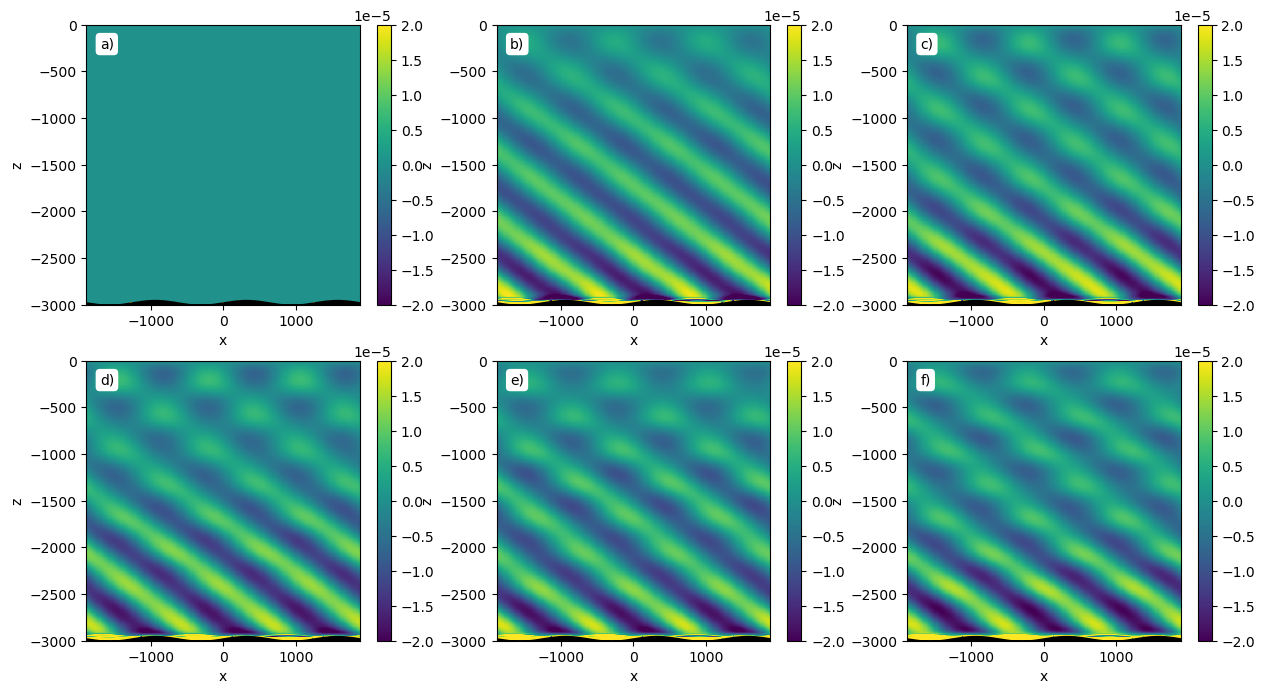

In [170]:
vmin=-2e-5
vmax=2e-5

fig, ax  = plt.subplots(2, 3, figsize=(15,8))

p0 = ax[0,0].pcolormesh(xx, zz, ds0_bvals - B, vmin=vmin, vmax=vmax)
p1 = ax[0,1].pcolormesh(xx, zz, ds1_bvals - B, vmin=vmin, vmax=vmax)
p2 = ax[0,2].pcolormesh(xx, zz, ds2_bvals - B, vmin=vmin, vmax=vmax)
p3 = ax[1,0].pcolormesh(xx, zz, ds3_bvals - B, vmin=vmin, vmax=vmax)
p4 = ax[1,1].pcolormesh(xx, zz, ds4_bvals - B, vmin=vmin, vmax=vmax)
p5 = ax[1,2].pcolormesh(xx, zz, ds5_bvals - B, vmin=vmin, vmax=vmax)

ax[0,0].set_xlabel('x')
ax[0,1].set_xlabel('x')
ax[0,2].set_xlabel('x')
ax[1,0].set_xlabel('x')
ax[1,1].set_xlabel('x')
ax[1,2].set_xlabel('x')

ax[0,0].set_ylabel('z')
ax[0,1].set_ylabel('z')
ax[0,2].set_ylabel('z')
ax[1,0].set_ylabel('z')
ax[1,1].set_ylabel('z')
ax[1,2].set_ylabel('z')

# fill topography with black
h0 = 25
H = 3000
k = 0.005
topo = h0 * (1 + np.sin(x_values * k)) - H
bottom = -H*np.ones_like(topo)

ax[0,0].fill_between(x_values, topo, bottom, color="k")
ax[0,1].fill_between(x_values, topo, bottom, color="k")
ax[0,2].fill_between(x_values, topo, bottom, color="k")
ax[1,0].fill_between(x_values, topo, bottom, color="k")
ax[1,1].fill_between(x_values, topo, bottom, color="k")
ax[1,2].fill_between(x_values, topo, bottom, color="k")

text_x = -1700
text_y = -250
bbox=dict(facecolor='white', edgecolor='none', boxstyle='round')
ax[0,0].text(text_x, text_y, 'a)', bbox=bbox)
ax[0,1].text(text_x, text_y, 'b)', bbox=bbox)
ax[0,2].text(text_x, text_y, 'c)', bbox=bbox)
ax[1,0].text(text_x, text_y, 'd)', bbox=bbox)
ax[1,1].text(text_x, text_y, 'e)', bbox=bbox)
ax[1,2].text(text_x, text_y, 'f)', bbox=bbox)

fig.colorbar(p0, ax=ax[0,0])
fig.colorbar(p1, ax=ax[0,1])
fig.colorbar(p2, ax=ax[0,2])
fig.colorbar(p3, ax=ax[1,0])
fig.colorbar(p4, ax=ax[1,1])
fig.colorbar(p5, ax=ax[1,2])

plt.savefig('lee_wave_5days.png', bbox_inches='tight')

In [171]:
# linear solver setup
from solver import LeeWaveSolver
import cmocean

k = 0.005
Lp5 = 3*np.pi/k
solver = LeeWaveSolver(nx=250, nz=501, H=3000, L=Lp5)

h_vals = h0 * (1 + np.sin(k * solver.x))
solver.set_topo(topo_type='Custom', h_input=h_vals)

N = 1e-3
Fr = 0.25
U0 = N * h0 / Fr

solver.set_mean_velocity(U_type='Uniform', U_0=U0)
solver.set_mean_stratification(N_type='Uniform', N_0=N, N_H=N)
solver.solve(f=1e-4, open_boundary=False, hydrostatic=False, Ah=1.0)
# solver.plot(solver.wave_fields.b)

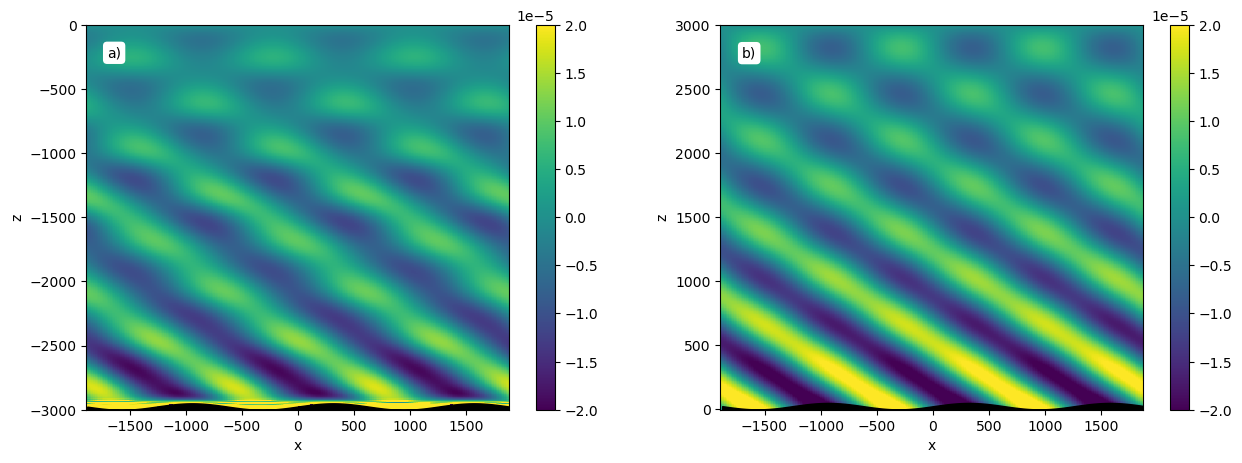

In [172]:
# comparison between simulation and linear solver
solver_xx, solver_zz = np.meshgrid(solver.wave_fields.x, solver.wave_fields.z)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
p1 = ax[0].pcolormesh(xx, zz, ds_lagrangian.b[mid_index,:,0,:] - B,vmin=vmin,vmax=vmax)
p2 = ax[1].pcolormesh(solver_xx.T, solver_zz.T, solver.wave_fields.b,vmin=vmin, vmax=vmax)

ax[0].set_xlabel('x')
ax[1].set_xlabel('x')
ax[0].set_ylabel('z')
ax[1].set_ylabel('z')

solver_topo = h0 * (1 + np.sin(k * solver.wave_fields.x))
solver_bottom = np.zeros_like(solver_topo)
ax[0].fill_between(x_values, topo, bottom, color="k")
ax[1].fill_between(x_values, solver_topo, solver_bottom, color="k")

text_x = -1700
text_y = -250
bbox=dict(facecolor='white', edgecolor='none', boxstyle='round')
ax[0].text(text_x, text_y, 'a)', bbox=bbox)
ax[1].text(text_x, 3000 + text_y, 'b)', bbox=bbox)

fig.colorbar(p1, ax=ax[0])
fig.colorbar(p2, ax=ax[1])
plt.savefig('lee_wave_vs_solver.png', bbox_inches='tight')

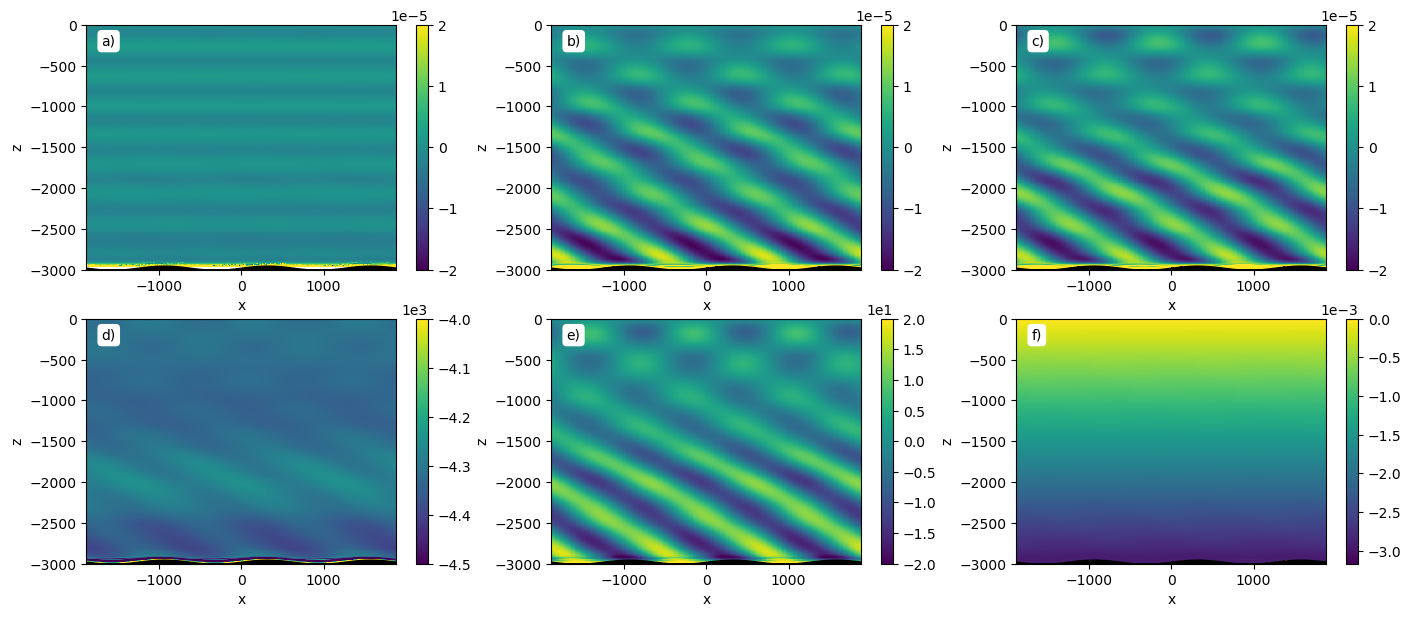

In [173]:
fig, ax = plt.subplots(2, 3, figsize=(17,7))

p1 = ax[0,0].pcolormesh(xx, zz, interped_scalar - B, vmin=vmin, vmax=vmax)
p2 = ax[0,1].pcolormesh(xx, zz, ds_lagrangian.b[mid_index,:,0,:].values - B, vmin=vmin, vmax=vmax)
p3 = ax[0,2].pcolormesh(xx, zz, ds_lagrangian.b_LM[-1,:,0,:].values - B, vmin=vmin, vmax=vmax)
p4 = ax[1,0].pcolormesh(xx, zz, ds_lagrangian.xix[-1,:,0,:].values, vmin=-4.5e3, vmax=-4e3)
p5 = ax[1,1].pcolormesh(xx, zz, ds_lagrangian.xiz[-1,:,0,:].values, vmin=-20, vmax=20)
# ax[0,2].contour(xx, zz, ds_lagrangian.b_LM[-1,:,0,:].values, levels=20, linewidths=0.4, colors='k')
p6 = ax[1,2].pcolormesh(xx, zz, ds_lagrangian.b[0,:,0,:].values)

ax[0,0].set_xlabel('x')
ax[0,1].set_xlabel('x')
ax[0,2].set_xlabel('x')
ax[1,0].set_xlabel('x')
ax[1,1].set_xlabel('x')
ax[1,2].set_xlabel('x')

ax[0,0].set_ylabel('z')
ax[0,1].set_ylabel('z')
ax[0,2].set_ylabel('z')
ax[1,0].set_ylabel('z')
ax[1,1].set_ylabel('z')
ax[1,2].set_ylabel('z')

# ax[0,0].set_title("interpolated LM - background b")
# ax[0,1].set_title("b at time t^* - background b")
# ax[0,2].set_title("b tilde - background b")
# ax[1,0].set_title("xi_x")
# ax[1,1].set_title("xi_z")
# ax[1,2].set_title("background buoyancy")

ax[0,0].fill_between(x_values, topo, bottom, color="k")
ax[0,1].fill_between(x_values, topo, bottom, color="k")
ax[0,2].fill_between(x_values, topo, bottom, color="k")
ax[1,0].fill_between(x_values, topo, bottom, color="k")
ax[1,1].fill_between(x_values, topo, bottom, color="k")
ax[1,2].fill_between(x_values, topo, bottom, color="k")

text_x = -1700
text_y = -250
bbox=dict(facecolor='white', edgecolor='none', boxstyle='round')
ax[0,0].text(text_x, text_y, 'a)', bbox=bbox)
ax[0,1].text(text_x, text_y, 'b)', bbox=bbox)
ax[0,2].text(text_x, text_y, 'c)', bbox=bbox)
ax[1,0].text(text_x, text_y, 'd)', bbox=bbox)
ax[1,1].text(text_x, text_y, 'e)', bbox=bbox)
ax[1,2].text(text_x, text_y, 'f)', bbox=bbox)

cbar1 = fig.colorbar(p1,ax=ax[0,0])
cbar2 = fig.colorbar(p2,ax=ax[0,1])
cbar3 = fig.colorbar(p3, ax=ax[0,2])
cbar4 = fig.colorbar(p4, ax=ax[1,0])
cbar5 = fig.colorbar(p5, ax=ax[1,1])
cbar6 = fig.colorbar(p6, ax=ax[1,2])

cbar1.formatter.set_powerlimits((0,0))
cbar2.formatter.set_powerlimits((0,0))
cbar3.formatter.set_powerlimits((0,0))
cbar4.formatter.set_powerlimits((0,0))
cbar5.formatter.set_powerlimits((0,0))
cbar6.formatter.set_powerlimits((0,0))

plt.savefig('lee_wave_lagrangian_xi.png', bbox_inches='tight')

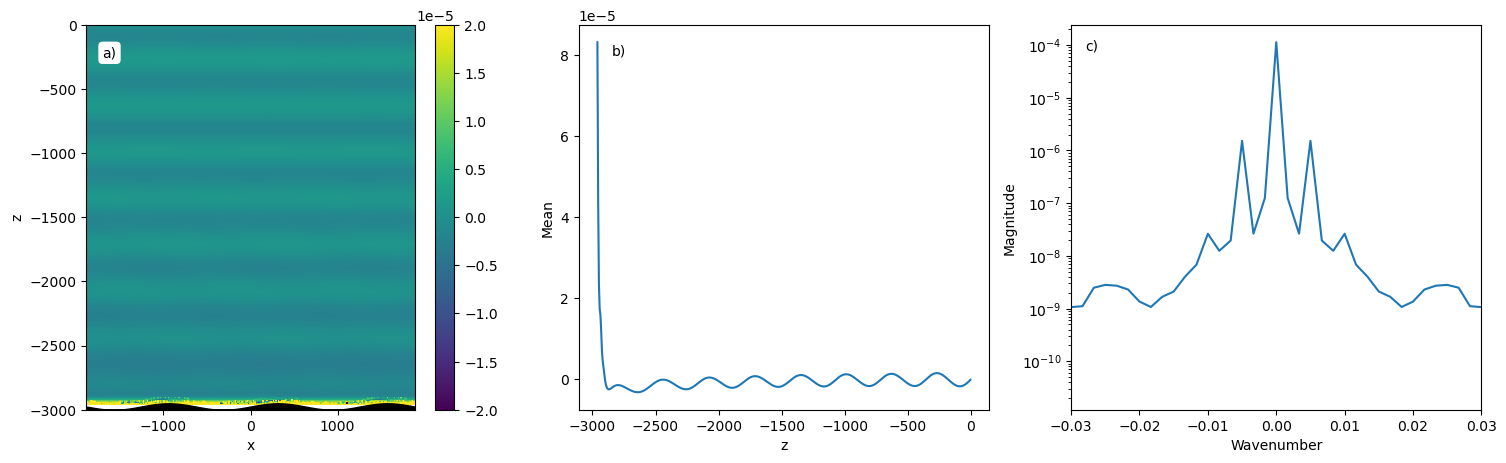

In [174]:
b = interped_scalar - B
b_fft = fftshift(fft(b[100:,:], axis=1).mean(axis=0))

k_topo = 0.005
dom_length = 6 * np.pi / k_topo
dx = dom_length / 250
k = 2*np.pi*fftshift(fftfreq(250, dx))

means_vec = []
for i in range(len(z_values)):
    means_vec.append(np.mean(interped_scalar[i] - B[i]))

fig, ax = plt.subplots(1, 3, figsize=(18, 5))
p1 = ax[0].pcolormesh(xx, zz, interped_scalar - B, vmin=vmin, vmax=vmax)
ax[0].set_xlabel('x')
ax[0].set_ylabel('z')
ax[0].fill_between(x_values, topo, bottom, color="k")
cbar1 = fig.colorbar(p1,ax=ax[0])
cbar1.formatter.set_powerlimits((0,0))

ax[1].plot(z_values, means_vec)
ax[1].set_xlabel('z')
ax[1].set_ylabel('Mean')

ax[2].plot(k, np.abs(b_fft))
ax[2].set_yscale("log")
ax[2].set_xlim(-0.03, 0.03)
ax[2].set_xlabel('Wavenumber')
ax[2].set_ylabel('Magnitude')

text_x = -1700
text_y = -250
bbox=dict(facecolor='white', edgecolor='none', boxstyle='round')
ax[0].text(text_x, text_y, 'a)', bbox=bbox)
ax[1].text(-2850, 8e-5, 'b)', bbox=bbox)
ax[2].text(-0.028, 0.8e-4, 'c)', bbox=bbox)

plt.savefig('lee_wave_fft.png', bbox_inches='tight')

Text(0, 0.5, 'mean')

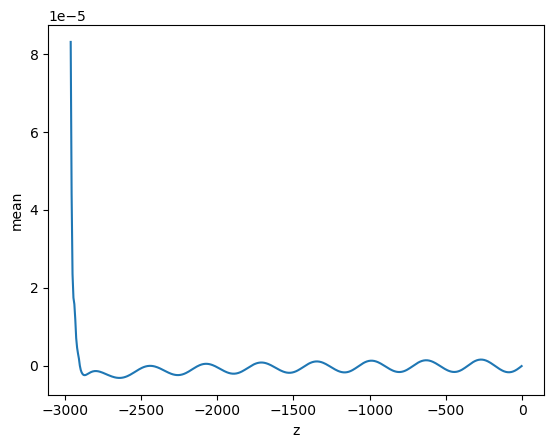

In [175]:
means_vec = []
for i in range(len(z_values)):
    means_vec.append(np.mean(interped_scalar[i] - B[i]))

plt.plot(z_values, means_vec)
plt.xlabel('z')
plt.ylabel('mean')

In [176]:
ds_evan0 = xr.open_dataset("evan_day0.nc")
ds_evan1 = xr.open_dataset("evan_day1.nc")
ds_evan2 = xr.open_dataset("evan_day2.nc")
ds_evan3 = xr.open_dataset("evan_day3.nc")
ds_evan4 = xr.open_dataset("evan_day4.nc")
ds_evan_lagrangian = xr.open_dataset("evan_filtered.nc")

ds_evan0_bvals = ds_evan0.b[0,:,0,:].values
ds_evan1_bvals = ds_evan1.b[0,:,0,:].values
ds_evan2_bvals = ds_evan2.b[0,:,0,:].values
ds_evan3_bvals = ds_evan3.b[0,:,0,:].values
ds_evan4_bvals = ds_evan4.b[0,:,0,:].values
ds_evan5_bvals = ds_evan_lagrangian.b[0,:,0,:]

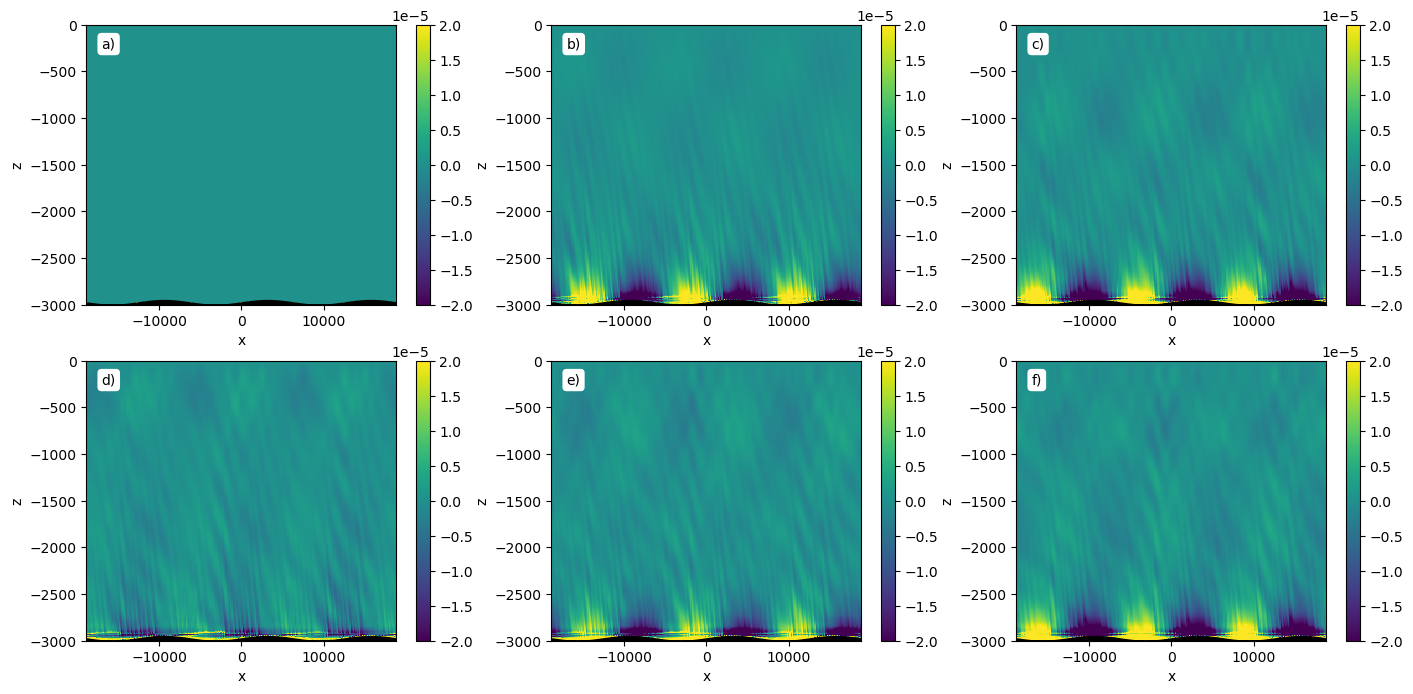

In [177]:
vmin=-2e-5
vmax=2e-5

x_values = ds_evan0.b.xC
z_values = ds_evan0.b.zC
xx, zz = np.meshgrid(x_values, z_values)

N2 = 1e-6
B = N2 * zz # background buoyancy

fig, ax  = plt.subplots(2, 3, figsize=(17,8))

p0 = ax[0,0].pcolormesh(xx, zz, ds_evan0_bvals - B, vmin=vmin, vmax=vmax)
p1 = ax[0,1].pcolormesh(xx, zz, ds_evan1_bvals - B, vmin=vmin, vmax=vmax)
p2 = ax[0,2].pcolormesh(xx, zz, ds_evan2_bvals - B, vmin=vmin, vmax=vmax)
p3 = ax[1,0].pcolormesh(xx, zz, ds_evan3_bvals - B, vmin=vmin, vmax=vmax)
p4 = ax[1,1].pcolormesh(xx, zz, ds_evan4_bvals - B, vmin=vmin, vmax=vmax)
p5 = ax[1,2].pcolormesh(xx, zz, ds_evan5_bvals - B, vmin=vmin, vmax=vmax)

ax[0,0].set_xlabel('x')
ax[0,1].set_xlabel('x')
ax[0,2].set_xlabel('x')
ax[1,0].set_xlabel('x')
ax[1,1].set_xlabel('x')
ax[1,2].set_xlabel('x')

ax[0,0].set_ylabel('z')
ax[0,1].set_ylabel('z')
ax[0,2].set_ylabel('z')
ax[1,0].set_ylabel('z')
ax[1,1].set_ylabel('z')
ax[1,2].set_ylabel('z')

# fill topography with black
h0 = 25
H = 3000
k = 0.0005
evan_topo = h0 * (1 + np.sin(x_values * k)) - H
bottom = -H*np.ones_like(evan_topo)

ax[0,0].fill_between(x_values, evan_topo, bottom, color="k")
ax[0,1].fill_between(x_values, evan_topo, bottom, color="k")
ax[0,2].fill_between(x_values, evan_topo, bottom, color="k")
ax[1,0].fill_between(x_values, evan_topo, bottom, color="k")
ax[1,1].fill_between(x_values, evan_topo, bottom, color="k")
ax[1,2].fill_between(x_values, evan_topo, bottom, color="k")

fig.colorbar(p0, ax=ax[0,0])
fig.colorbar(p1, ax=ax[0,1])
fig.colorbar(p2, ax=ax[0,2])
fig.colorbar(p3, ax=ax[1,0])
fig.colorbar(p4, ax=ax[1,1])
fig.colorbar(p5, ax=ax[1,2])

text_x = -17000
text_y = -250
bbox=dict(facecolor='white', edgecolor='none', boxstyle='round')
ax[0,0].text(text_x, text_y, 'a)', bbox=bbox)
ax[0,1].text(text_x, text_y, 'b)', bbox=bbox)
ax[0,2].text(text_x, text_y, 'c)', bbox=bbox)
ax[1,0].text(text_x, text_y, 'd)', bbox=bbox)
ax[1,1].text(text_x, text_y, 'e)', bbox=bbox)
ax[1,2].text(text_x, text_y, 'f)', bbox=bbox)

plt.savefig('evan_5days.png', bbox_inches='tight')

In [178]:
scalar_data_evan = np.load("scalar_data_evan.npy")
coord_data_evan = np.load("coord_data_evan.npy")

interp = LinearNDInterpolator(list(zip(np.ravel(coord_data_evan[1,:]), np.ravel(coord_data_evan[0,:]))), np.ravel(scalar_data_evan))

interped_scalar_evan = interp(zz, xx)
N2 = 1e-6
B = N2 * zz
mid_index = int(len(ds_evan_lagrangian.b)/2)
vmin=-2e-5
vmax=2e-5

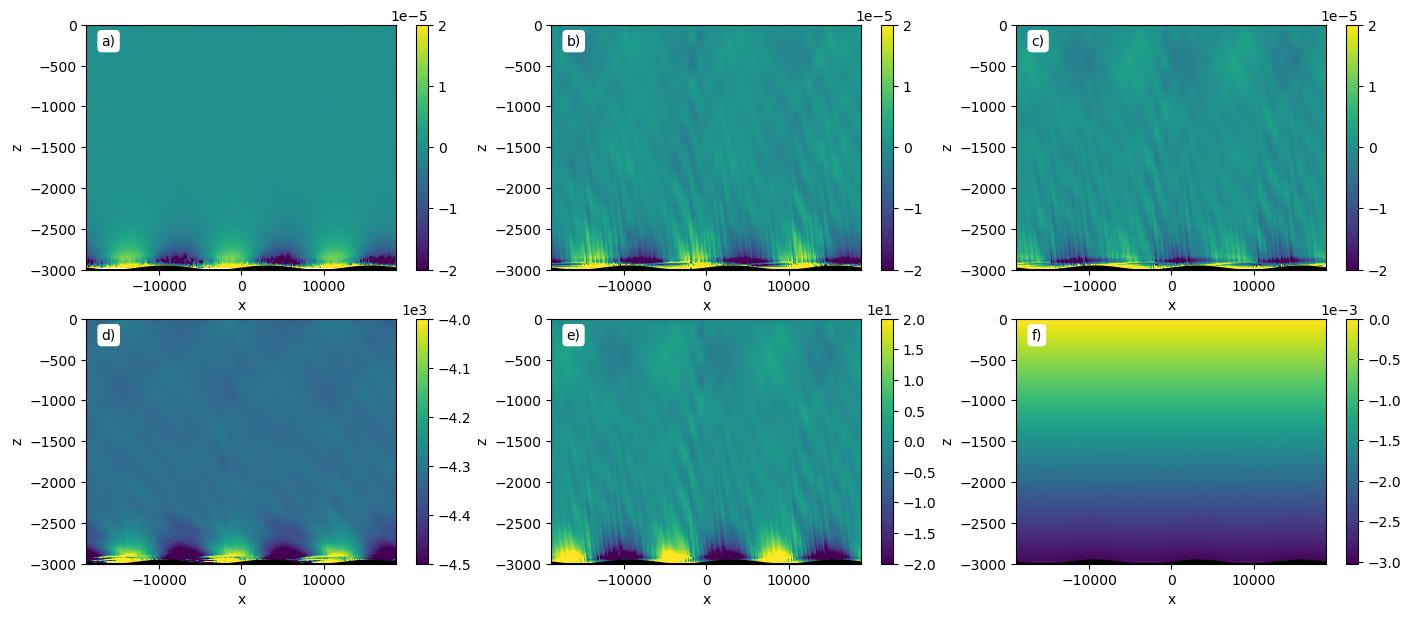

In [179]:
fig, ax = plt.subplots(2, 3, figsize=(17,7))

p1 = ax[0,0].pcolormesh(xx, zz, interped_scalar_evan - B, vmin=vmin, vmax=vmax)
p2 = ax[0,1].pcolormesh(xx, zz, ds_evan_lagrangian.b[mid_index,:,0,:].values - B, vmin=vmin, vmax=vmax)
p3 = ax[0,2].pcolormesh(xx, zz, ds_evan_lagrangian.b_LM[-1,:,0,:].values - B, vmin=vmin, vmax=vmax)
p4 = ax[1,0].pcolormesh(xx, zz, ds_evan_lagrangian.xix[-1,:,0,:].values, vmin=-4.5e3, vmax=-4e3)
p5 = ax[1,1].pcolormesh(xx, zz, ds_evan_lagrangian.xiz[-1,:,0,:].values, vmin=-20, vmax=20)
p6 = ax[1,2].pcolormesh(xx, zz, ds_evan_lagrangian.b[0,:,0,:].values)

ax[0,0].set_xlabel('x')
ax[0,1].set_xlabel('x')
ax[0,2].set_xlabel('x')
ax[1,0].set_xlabel('x')
ax[1,1].set_xlabel('x')
ax[1,2].set_xlabel('x')

ax[0,0].set_ylabel('z')
ax[0,1].set_ylabel('z')
ax[0,2].set_ylabel('z')
ax[1,0].set_ylabel('z')
ax[1,1].set_ylabel('z')
ax[1,2].set_ylabel('z')

# ax[0,2].contour(xx, zz, ds_evan_lagrangian.b_LM[-1,:,0,:].values, levels=20, linewidths=0.4, colors='k')
# ax[0,0].set_title("interpolated LM - background b")
# ax[0,1].set_title("b at time t^* - background b")
# ax[0,2].set_title("b tilde - background b")
# ax[1,0].set_title("xi_x")
# ax[1,1].set_title("xi_z")
# ax[1,2].set_title("background buoyancy")

ax[0,0].fill_between(x_values, evan_topo, bottom, color="k")
ax[0,1].fill_between(x_values, evan_topo, bottom, color="k")
ax[0,2].fill_between(x_values, evan_topo, bottom, color="k")
ax[1,0].fill_between(x_values, evan_topo, bottom, color="k")
ax[1,1].fill_between(x_values, evan_topo, bottom, color="k")
ax[1,2].fill_between(x_values, evan_topo, bottom, color="k")

text_x = -17000
text_y = -250
bbox=dict(facecolor='white', edgecolor='none', boxstyle='round')
ax[0,0].text(text_x, text_y, 'a)', bbox=bbox)
ax[0,1].text(text_x, text_y, 'b)', bbox=bbox)
ax[0,2].text(text_x, text_y, 'c)', bbox=bbox)
ax[1,0].text(text_x, text_y, 'd)', bbox=bbox)
ax[1,1].text(text_x, text_y, 'e)', bbox=bbox)
ax[1,2].text(text_x, text_y, 'f)', bbox=bbox)

cbar1 = fig.colorbar(p1,ax=ax[0,0])
cbar2 = fig.colorbar(p2,ax=ax[0,1])
cbar3 = fig.colorbar(p3, ax=ax[0,2])
cbar4 = fig.colorbar(p4, ax=ax[1,0])
cbar5 = fig.colorbar(p5, ax=ax[1,1])
cbar6 = fig.colorbar(p6, ax=ax[1,2])

cbar1.formatter.set_powerlimits((0,0))
cbar2.formatter.set_powerlimits((0,0))
cbar3.formatter.set_powerlimits((0,0))
cbar4.formatter.set_powerlimits((0,0))
cbar5.formatter.set_powerlimits((0,0))
cbar6.formatter.set_powerlimits((0,0))

plt.savefig('evan_lagrangian_xis.png', bbox_inches='tight')

In [180]:
from solver import LeeWaveSolver

h0 = 25
k = 0.0005
Lp5 = 3*np.pi/k
solver = LeeWaveSolver(nx=250, nz=501, H=3000, L=Lp5)

h_vals = h0 * (1 + np.sin(k * solver.x))
solver.set_topo(topo_type='Custom', h_input=h_vals)

N = 1e-3
Fr = 0.25
U0 = N * h0 / Fr

solver.set_mean_velocity(U_type='Uniform', U_0=U0)
solver.set_mean_stratification(N_type='Uniform', N_0=N, N_H=N)
solver.solve(f=1e-4, open_boundary=False, hydrostatic=False, Ah=1.0)

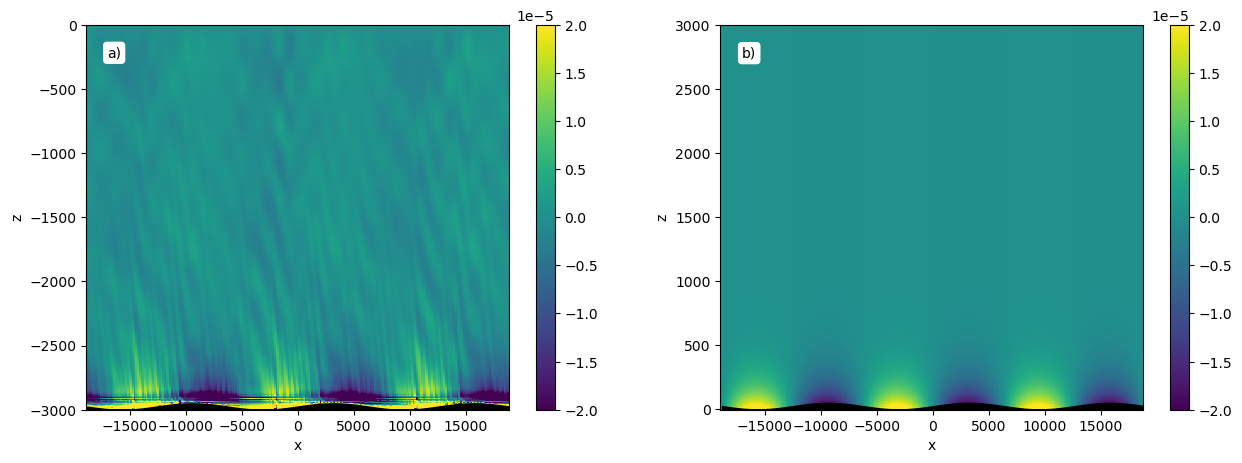

In [181]:
solver_xx, solver_zz = np.meshgrid(solver.wave_fields.x, solver.wave_fields.z)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
p1 = ax[0].pcolormesh(xx, zz, ds_evan_lagrangian.b[mid_index,:,0,:] - B,vmin=vmin,vmax=vmax)
p2 = ax[1].pcolormesh(solver_xx.T, solver_zz.T, solver.wave_fields.b,vmin=vmin, vmax=vmax)

ax[0].set_xlabel('x')
ax[1].set_xlabel('x')
ax[0].set_ylabel('z')
ax[1].set_ylabel('z')

solver_topo = h0 * (1 + np.sin(k * solver.wave_fields.x))
solver_bottom = np.zeros_like(solver_topo)
ax[0].fill_between(x_values, topo, bottom, color="k")
ax[1].fill_between(x_values, solver_topo, solver_bottom, color="k")

text_x = -17000
text_y = -250
bbox=dict(facecolor='white', edgecolor='none', boxstyle='round')
ax[0].text(text_x, text_y, 'a)', bbox=bbox)
ax[1].text(text_x, 3000 + text_y, 'b)', bbox=bbox)

fig.colorbar(p1, ax=ax[0])
fig.colorbar(p2, ax=ax[1])

plt.savefig('evan_vs_solver.png', bbox_inches='tight')

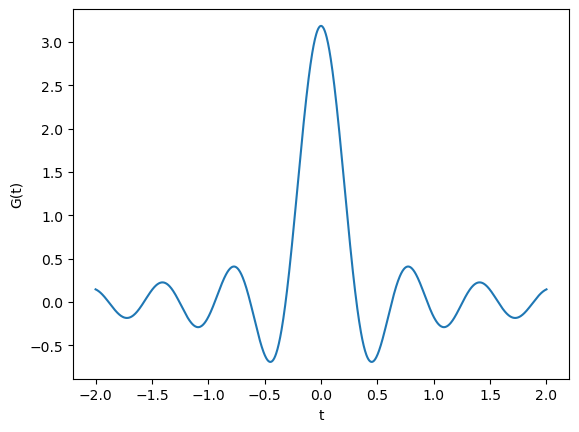

In [182]:
# weight function
x = np.linspace(-2, 2, 1000)
omega_c = 10
y = np.sin(omega_c*x)/(np.pi * x)
plt.plot(x, y)
plt.xlabel('t')
plt.ylabel('G(t)')

plt.savefig('G_weight.png', bbox_inches='tight')